In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.preprocessing import MinMaxScaler,StandardScaler,Normalizer,RobustScaler
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import log_loss, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from keras.optimizers import SGD, Adam, RMSprop, Nadam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve


In [2]:
stroke = pd.read_excel("full_data_new.xlsx")

In [3]:
stroke

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
4137,Male,41.0,0,0,No,Private,Rural,70.15,29.8,formerly smoked,0
4138,Male,40.0,0,0,Yes,Private,Urban,191.15,31.1,smokes,0
4139,Female,45.0,1,0,Yes,Govt_job,Rural,95.02,31.8,smokes,0
4140,Male,40.0,0,0,Yes,Private,Rural,83.94,30.0,smokes,0


In [4]:
stroke['stroke'].value_counts()

stroke
0    3939
1     203
Name: count, dtype: int64

In [5]:
stroke['work_type'].value_counts()

work_type
Private          2284
children          673
Self-employed     659
Govt_job          526
Name: count, dtype: int64

In [6]:
stroke['Residence_type'].value_counts()

Residence_type
Urban    2108
Rural    2034
Name: count, dtype: int64

In [7]:
stroke['smoking_status'].value_counts()

smoking_status
never smoked       2499
formerly smoked     867
smokes              776
Name: count, dtype: int64

In [8]:
df = stroke.copy()

gender_mapping = {'Male': 1, 'Female': 0}
ever_married_mapping = {'Yes': 1, 'No': 0}
work_type_mapping = {'Private': 0, 'Self-employed': 1, 'Govt_job': 2, 'children': 3}
residence_type_mapping = {'Urban': 1, 'Rural': 0}
smoking_status_mapping = {'never smoked': 0,'formerly smoked': 1, 'smokes': 2}

# Lakukan label encoding
df['gender'] = df['gender'].map(gender_mapping)
df['ever_married'] = df['ever_married'].map(ever_married_mapping)
df['work_type'] = df['work_type'].map(work_type_mapping)
df['Residence_type'] = df['Residence_type'].map(residence_type_mapping)
df['smoking_status'] = df['smoking_status'].map(smoking_status_mapping)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4142 entries, 0 to 4141
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4142 non-null   int64  
 1   age                4142 non-null   float64
 2   hypertension       4142 non-null   int64  
 3   heart_disease      4142 non-null   int64  
 4   ever_married       4142 non-null   int64  
 5   work_type          4142 non-null   int64  
 6   Residence_type     4142 non-null   int64  
 7   avg_glucose_level  4142 non-null   float64
 8   bmi                4142 non-null   float64
 9   smoking_status     4142 non-null   int64  
 10  stroke             4142 non-null   int64  
dtypes: float64(3), int64(8)
memory usage: 356.1 KB


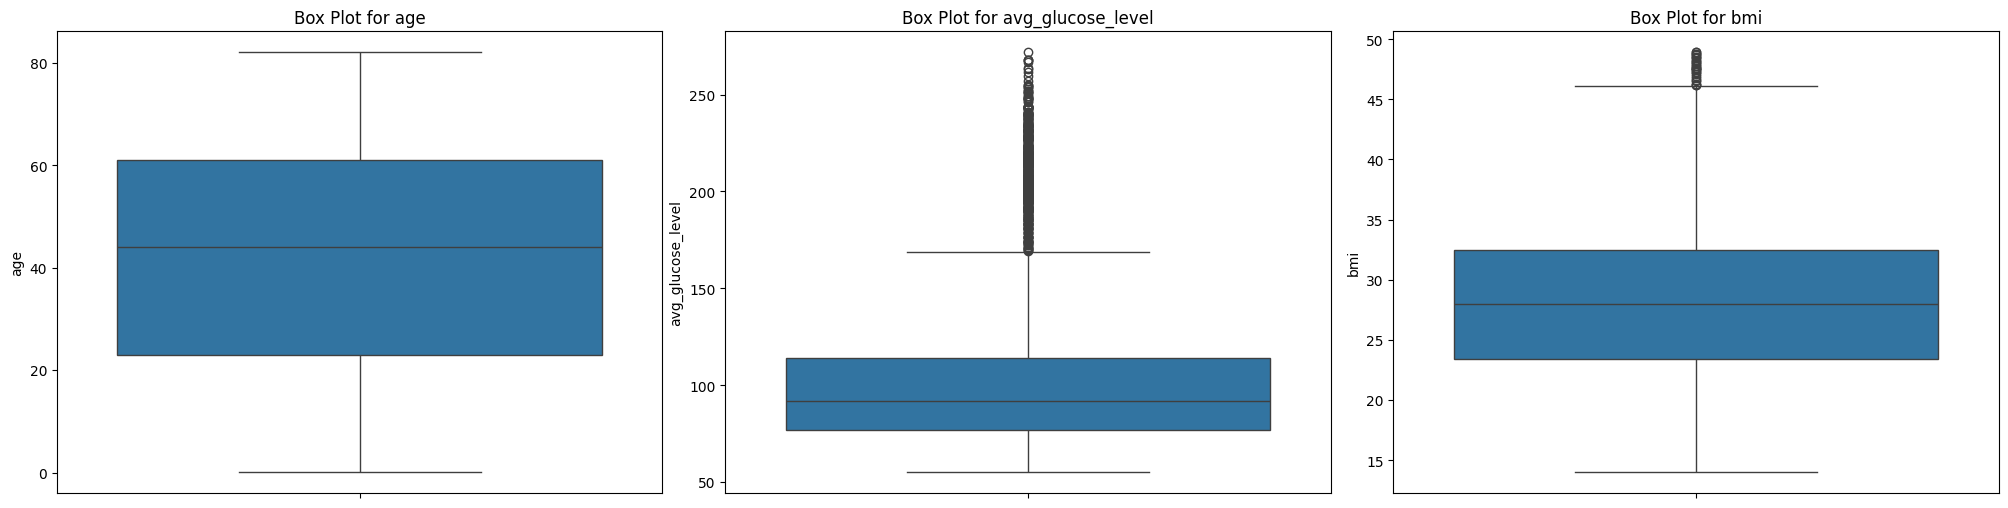

In [10]:
#Identifikasi outlier
numeric_columns = ['age', 'avg_glucose_level', 'bmi']

fig, axs = plt.subplots(ncols=len(numeric_columns), figsize=(20, 5))

for i, column in enumerate(numeric_columns):
    sns.boxplot(y=column, data=df, ax=axs[i], whis=1.5)
    axs[i].set_title(f'Box Plot for {column}')
    axs[i].set_xlabel('')

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)
plt.show()

In [11]:
# Penghapusan outlier
iqr_threshold = 1.5

for column in numeric_columns:
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - iqr_threshold * iqr
    upper_bound = q3 + iqr_threshold * iqr
    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [12]:
# Transformasi logaritma
df['avg_glucose_level'] = np.log(df['avg_glucose_level'])
df['bmi'] = np.log(df['bmi'])

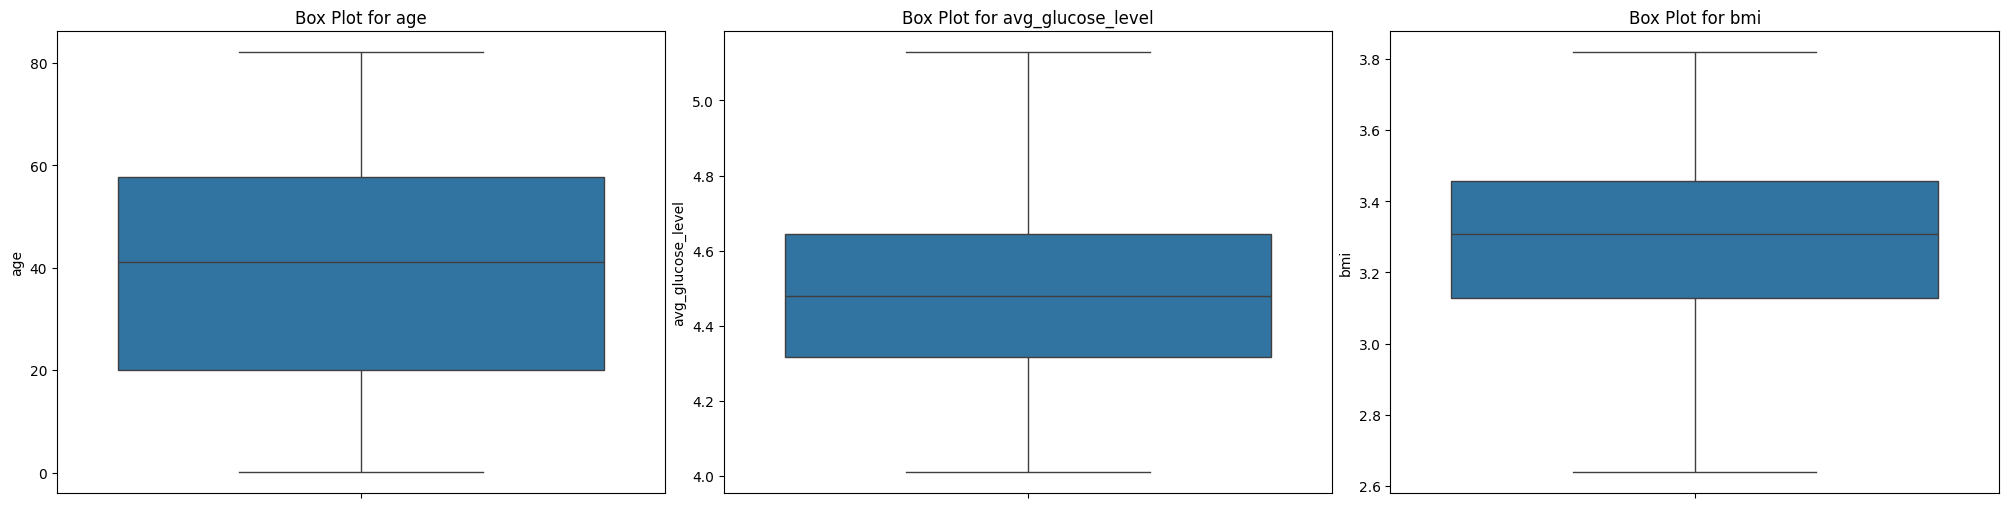

In [13]:
# Pemeriksaan outlier
fig, axs = plt.subplots(ncols=len(numeric_columns), figsize=(20, 5))

for i, column in enumerate(numeric_columns):
    sns.boxplot(y=column, data=df, ax=axs[i], whis=1.5)
    axs[i].set_title(f'Box Plot for {column}')
    axs[i].set_xlabel('')

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)
plt.show()

In [14]:
# Membagi data menjadi fitur (X) dan target (y)
X = df.drop(columns=['stroke'])
y = df['stroke']

In [15]:
# Pemisahan data menjadi data pelatihan dan pengujian
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45545)

In [16]:
# Normalisasi data
numerical_columns = ['age', 'avg_glucose_level', 'bmi']
scaler = StandardScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

In [17]:
# Menerapkan SMOTE untuk mengatasi imbalanced data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [18]:
# Membuat model Neural Network
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, input_dim= 10 ,activation = "relu"),
    tf.keras.layers.Dense(8,activation = "relu"),
    tf.keras.layers.Dense(1, activation = "sigmoid")
])

model.compile(optimizer= RMSprop(learning_rate = 0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


history = model.fit(X_train_resampled, y_train_resampled, epochs=100, batch_size=20, validation_split = 0.1)


Epoch 1/100
250/250 [==============================] - 3s 8ms/step - loss: 0.6962 - accuracy: 0.5156 - val_loss: 0.7028 - val_accuracy: 0.4065
Epoch 2/100
250/250 [==============================] - 1s 6ms/step - loss: 0.6543 - accuracy: 0.6333 - val_loss: 0.6940 - val_accuracy: 0.5324
Epoch 3/100
250/250 [==============================] - 1s 4ms/step - loss: 0.6067 - accuracy: 0.7215 - val_loss: 0.6489 - val_accuracy: 0.7050
Epoch 4/100
250/250 [==============================] - 1s 3ms/step - loss: 0.5565 - accuracy: 0.7735 - val_loss: 0.6115 - val_accuracy: 0.7608
Epoch 5/100
250/250 [==============================] - 1s 4ms/step - loss: 0.5190 - accuracy: 0.7891 - val_loss: 0.5769 - val_accuracy: 0.7932
Epoch 6/100
250/250 [==============================] - 1s 4ms/step - loss: 0.4931 - accuracy: 0.7965 - val_loss: 0.5432 - val_accuracy: 0.8112
Epoch 7/100
250/250 [==============================] - 1s 4ms/step - loss: 0.4750 - accuracy: 0.8023 - val_loss: 0.5226 - val_accuracy: 0.8165

23/23 [==============================] - 0s 2ms/step - loss: 0.3283 - accuracy: 0.8350
Accuracy: 83.50%


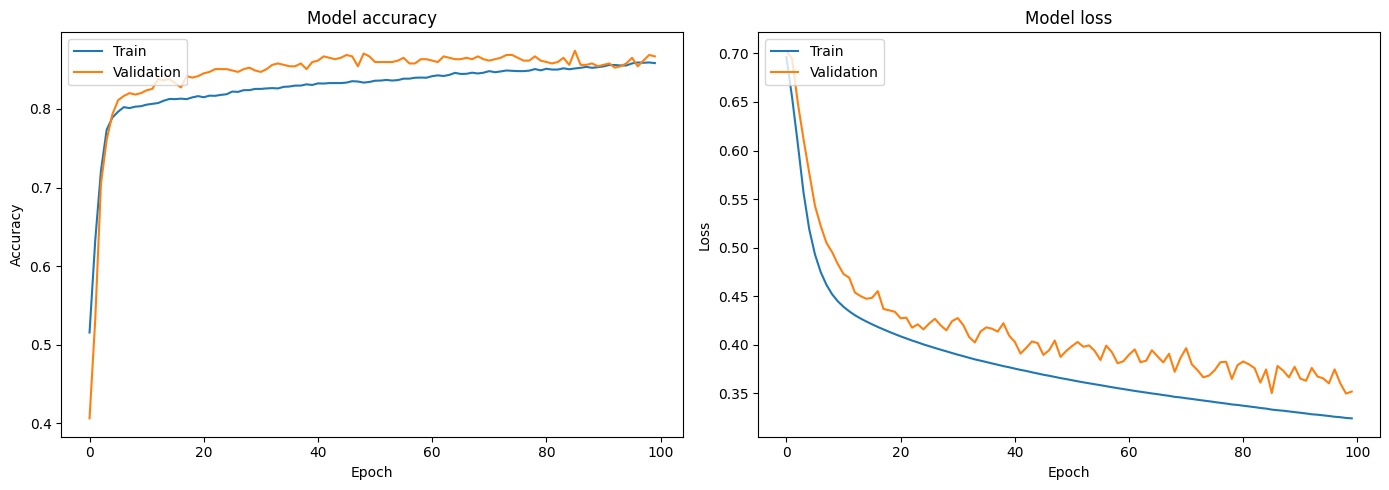

In [19]:
# Evaluasi model pada data testing
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Visualisasi loss dan accuracy
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


23/23 [==============================] - 0s 2ms/step


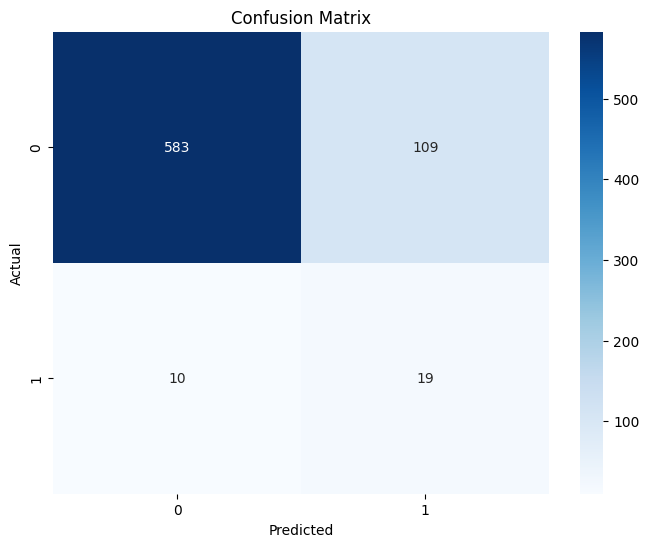

              precision    recall  f1-score   support

           0       0.98      0.84      0.91       692
           1       0.15      0.66      0.24        29

    accuracy                           0.83       721
   macro avg       0.57      0.75      0.57       721
weighted avg       0.95      0.83      0.88       721



In [20]:
from sklearn.metrics import confusion_matrix, classification_report

# Prediksi pada data testing
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Visualisasi Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_test, y_pred_classes))

In [21]:
# Menyimpan model neural network
model.save("/content/stroke.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [22]:
from tensorflow.keras.models import load_model
model = tf.keras.models.load_model("/content/stroke.h5")

In [23]:
#gender_mapping = {'Male': 1, 'Female': 0}
#ever_married_mapping = {'Yes': 1, 'No': 0}
#work_type_mapping = {'Private': 0, 'Self-employed': 1, 'Govt_job': 2, 'children': 3}
#residence_type_mapping = {'Urban': 1, 'Rural': 0}
#smoking_status_mapping = {'never smoked': 0,'formerly smoked': 1, 'smokes': 2}


In [24]:
# Data dummy
data_dummy = {
    'gender': [1],
    'age': [75],
    'hypertension': [0],
    'heart_disease': [1],
    'ever_married': [1],
    'work_type': [0],
    'Residence_type': [1],
    'avg_glucose_level': [230],
    'bmi': [40],
    'smoking_status': [2]
}

# Buat DataFrame langsung dari data dummy
new_df = pd.DataFrame(data_dummy)

# Asumsikan model sudah dilatih dan disimpan di 'model.h5'
# Load model (pastikan file model.h5 ada di direktori kerja Anda)
model = load_model('stroke.h5')

def classify_stroke(data):
    # Prediksi menggunakan model
    pred = np.argmax(model.predict(data), axis=1)[0]

    # Berikan label berdasarkan prediksi
    if pred == 1:
        label = "Stroke"
    elif pred == 0:
        label = "Not Stroke"

    return label

# Panggil fungsi classify_stroke dengan DataFrame
result = classify_stroke(new_df)
print(result)


1/1 [==============================] - 0s 60ms/step
Not Stroke
